In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from ast import literal_eval

from urllib.parse import urlparse

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer as PS

import joblib


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# data = pd.read_csv('dataset/full_dataset.csv')
data = pd.read_csv('../work/dataset/full_dataset.csv')

In [3]:
data.head()

Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com/Recipe-Details.aspx?id=44874  Gathered   
1  www.cookbooks.com/Recipe-Details.aspx?id=699419  Gathered   
2   www.cookbooks.com/Recipe-Details.aspx?id=10570  Gathered   
3  www.cookbooks.com/Recipe-Details.aspx?id=897570  Gathered   
4  www.cookbooks.com/Recipe-Details.aspx?id=659239  Gathered   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231142 entries, 0 to 2231141
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   title        object
 2   ingredients  object
 3   directions   object
 4   link         object
 5   source       object
 6   NER          object
dtypes: int64(1), object(6)
memory usage: 119.2+ MB


In [5]:
data.ingredients[0]

'["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]'

In [6]:
data.directions[0]

'["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]'

In [7]:
data.NER[0]

'["brown sugar", "milk", "vanilla", "nuts", "butter", "bite size shredded rice biscuits"]'

In [8]:
data.source.unique()

array(['Gathered', 'Recipes1M'], dtype=object)

In [9]:
data = data.loc[data['source'] == 'Gathered']

In [10]:
data.head()

Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com/Recipe-Details.aspx?id=44874  Gathered   
1  www.cookbooks.com/Recipe-Details.aspx?id=699419  Gathered   
2   www.cookbooks.com/Recipe-Details.aspx?id=10570  Gathered   
3  www.cookbooks.com/Recipe-Details.aspx?id=897570  Gathered   
4  www.cookbooks.com/Recipe-Details.aspx?id=659239  Gathered   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

In [11]:
data.source.unique()

array(['Gathered'], dtype=object)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643098 entries, 0 to 1643097
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   Unnamed: 0   1643098 non-null  int64 
 1   title        1643098 non-null  object
 2   ingredients  1643098 non-null  object
 3   directions   1643098 non-null  object
 4   link         1643098 non-null  object
 5   source       1643098 non-null  object
 6   NER          1643098 non-null  object
dtypes: int64(1), object(6)
memory usage: 100.3+ MB


In [13]:
toy_data = data.iloc[:5]
toy_data

Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com/Recipe-Details.aspx?id=44874  Gathered   
1  www.cookbooks.com/Recipe-Details.aspx?id=699419  Gathered   
2   www.cookbooks.com/Recipe-Details.aspx?id=10570  Gathered   
3  www.cookbooks.com/Recipe-Details.aspx?id=897570  Gathered   
4  www.cookbooks.com/Recipe-Details.aspx?id=659239  Gathered   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

In [14]:
toy_data = toy_data[['title','source']]
toy_data

title    source
0    No-Bake Nut Cookies  Gathered
1  Jewell Ball'S Chicken  Gathered
2            Creamy Corn  Gathered
3          Chicken Funny  Gathered
4   Reeses Cups(Candy)    Gathered

In [15]:
G = nx.Graph()

In [16]:
G = nx.from_pandas_edgelist(toy_data, 'title', 'source')

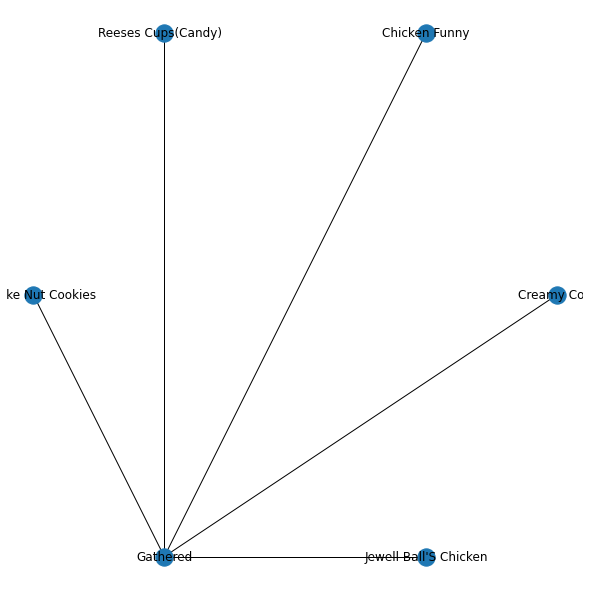

In [17]:
plt.figure(figsize=(8,8))
nx.draw_shell(G, with_labels=True)

In [18]:
def literal_return(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val

def df_str_to_literal(df, column_name):
    df[column_name] = df[column_name].apply(literal_return)
    return df[column_name]

In [19]:
toy_data = data.sample(frac=0.5, replace=False)
toy_data.head(10)

Unnamed: 0                                    title  \
1597583     1597583                              Sesame Slaw   
763056       763056                   Drop Chocolate Cookies   
373982       373982                    Libby'S Hot Dog Sauce   
675166       675166                        Texas Baked Beans   
613089       613089     Chicken And Dumplings(Aunt Edna'S)     
1556771     1556771  Sakura Mochi (Cherry Blossom Rice Cake)   
1527245     1527245         Blue Cheese & Berry Tossed Salad   
180777       180777                         Remarkable Fudge   
619505       619505                   Brown Sugar Pound Cake   
870315       870315                          Chocolate Pizza   

                                               ingredients  \
1597583  ["2 tablespoons sesame seeds toasted", "2 tabl...   
763056   ["1/2 c. cocoa", "1/2 c. shortening", "1 c. br...   
373982   ["1 lb. hamburger", "1 onion, chopped fine", "...   
675166   ["2 cans pork and beans", "lots of catsup", "1...   
613089   ["1/2 box Anne's frozen flat old fashioned chi...   
1556771  ["FOR THE MOCHI (PINK RICE CAKE):", "3 cups Sw...   
1527245  ["1 package (5 ounces) spring mix salad greens...   
180777   ["4 c. sugar", "10 oz. evaporated milk", "1 c....   
619505   ["3 c. all-purpose flour", "1 tsp. baking powd...   
870315   ["12 oz. pkg. chocolate chips", "14 oz. white ...   

                                                directions  \
1597583  ["Mix onion (or 1 T instant minced onion with ...   
763056   ["Melt shortening.", "Add sugar, egg, milk, so...   
373982   ["Brown hamburger and onion in oil.", "Add sal...   
675166   ["Cook hamburger in skillet; drain hamburger."...   
613089     ["Add more broth, or a little water if needed"]   
1556771  ["Tsubushi An (red bean filling):", "Wash bean...   
1527245  ["In a salad bowl, combine the salad greens, c...   
180777   ["Butter the sides of a heavy 3-quart saucepan...   
619505   ["Preheat oven to 325\u00b0.", "Grease and flo...   
870315   ["Melt in microwave first 2 ingredients.", "St...   

                                                      link    source  \
1597583          www.yummly.com/recipe/Sesame-Slaw-1673940  Gathered   
763056     www.cookbooks.com/Recipe-Details.aspx?id=606747  Gathered   
373982    www.cookbooks.com/Recipe-Details.aspx?id=1043406  Gathered   
675166     www.cookbooks.com/Recipe-Details.aspx?id=692416  Gathered   
613089     www.cookbooks.com/Recipe-Details.aspx?id=455092  Gathered   
1556771  tastykitchen.com/recipes/desserts/sakura-mochi...  Gathered   
1527245  www.tasteofhome.com/recipes/blue-cheese-berry-...  Gathered   
180777     www.cookbooks.com/Recipe-Details.aspx?id=903145  Gathered   
619505     www.cookbooks.com/Recipe-Details.aspx?id=711673  Gathered   
870315    www.cookbooks.com/Recipe-Details.aspx?id=1020804  Gathered   

                                                       NER  
1597583  ["sesame seeds", "onion", "sour cream", "musta...  
763056   ["cocoa", "shortening", "brown sugar", "soda",...  
373982   ["hamburger", "onion", "oil", "salt", "vinegar...  
675166   ["pork", "lots of catsup", "green pepper", "on...  
613089   ["chicken dumplings", "chicken broth", "chicke...  
1556771  ["MOCHI", "Sweet Rice", "Sugar", "Salt", "____...  
1527245  ["spring mix salad greens", "blue cheese", "fr...  
180777   ["sugar", "milk", "butter", "chocolate chips",...  
619505   ["all-purpose", "baking powder", "salt", "butt...  
870315   ["chocolate chips", "white chocolate bark", "m...

In [20]:
# toy_data.ingredients[1597583]

'["2 tablespoons sesame seeds toasted", "2 tablespoons onion finely chopped", "1 cup sour cream", "1 tablespoon dijon mustard", "1 teaspoon salt", "6 cups cabbage finely shredded", "1 cup mayonnaise"]'

In [21]:
def clean_df(df, columns_list):
    for col in columns_list:
        df[col] = df_str_to_literal(df, col)
    return None

In [22]:
clean_df(toy_data, ['ingredients', 'directions', 'NER'])

In [23]:
toy_data.head()

Unnamed: 0                                 title  \
1597583     1597583                           Sesame Slaw   
763056       763056                Drop Chocolate Cookies   
373982       373982                 Libby'S Hot Dog Sauce   
675166       675166                     Texas Baked Beans   
613089       613089  Chicken And Dumplings(Aunt Edna'S)     

                                               ingredients  \
1597583  [2 tablespoons sesame seeds toasted, 2 tablesp...   
763056   [1/2 c. cocoa, 1/2 c. shortening, 1 c. brown s...   
373982   [1 lb. hamburger, 1 onion, chopped fine, 2 Tbs...   
675166   [2 cans pork and beans, lots of catsup, 1 gree...   
613089   [1/2 box Anne's frozen flat old fashioned chic...   

                                                directions  \
1597583  [Mix onion (or 1 T instant minced onion with 1...   
763056   [Melt shortening., Add sugar, egg, milk, soda,...   
373982   [Brown hamburger and onion in oil., Add salt, ...   
675166   [Cook hamburger in skillet; drain hamburger., ...   
613089       [Add more broth, or a little water if needed]   

                                                     link    source  \
1597583         www.yummly.com/recipe/Sesame-Slaw-1673940  Gathered   
763056    www.cookbooks.com/Recipe-Details.aspx?id=606747  Gathered   
373982   www.cookbooks.com/Recipe-Details.aspx?id=1043406  Gathered   
675166    www.cookbooks.com/Recipe-Details.aspx?id=692416  Gathered   
613089    www.cookbooks.com/Recipe-Details.aspx?id=455092  Gathered   

                                                       NER  
1597583  [sesame seeds, onion, sour cream, mustard, sal...  
763056   [cocoa, shortening, brown sugar, soda, egg, fl...  
373982   [hamburger, onion, oil, salt, vinegar, sweet p...  
675166   [pork, lots of catsup, green pepper, onion, pe...  
613089   [chicken dumplings, chicken broth, chicken bou...

In [24]:
# toy_data.ingredients[1597583]

['2 tablespoons sesame seeds toasted',
 '2 tablespoons onion finely chopped',
 '1 cup sour cream',
 '1 tablespoon dijon mustard',
 '1 teaspoon salt',
 '6 cups cabbage finely shredded',
 '1 cup mayonnaise']

In [25]:
# toy_data.directions[1597583]

['Mix onion (or 1 T instant minced onion with 1 T water) with sour cream, mayo, Dijon & salt.',
 'If dressing made ahead, cover & refrigerate.']

In [26]:
# toy_data.NER[1597583]

['sesame seeds',
 'onion',
 'sour cream',
 'mustard',
 'salt',
 'cabbage',
 'mayonnaise']

In [27]:
# toy_data.link[1597583]

'www.yummly.com/recipe/Sesame-Slaw-1673940'

In [28]:
# path = urlparse(toy_data.link[0]).path
# path

In [29]:
# site = path.split('/')[0]
# site

In [30]:
def parse_link(link):
    path = urlparse(link).path
    site = path.split('/')[0]
    return site

def df_link_to_site(df, column_name, new_column_name):
    df[new_column_name] = df[column_name].apply(parse_link)
    return df[new_column_name]

In [31]:
# toy_data['site'] = df_link_to_site(toy_data, 'link', 'site')
# toy_data.head()

Unnamed: 0                                 title  \
1597583     1597583                           Sesame Slaw   
763056       763056                Drop Chocolate Cookies   
373982       373982                 Libby'S Hot Dog Sauce   
675166       675166                     Texas Baked Beans   
613089       613089  Chicken And Dumplings(Aunt Edna'S)     

                                               ingredients  \
1597583  [2 tablespoons sesame seeds toasted, 2 tablesp...   
763056   [1/2 c. cocoa, 1/2 c. shortening, 1 c. brown s...   
373982   [1 lb. hamburger, 1 onion, chopped fine, 2 Tbs...   
675166   [2 cans pork and beans, lots of catsup, 1 gree...   
613089   [1/2 box Anne's frozen flat old fashioned chic...   

                                                directions  \
1597583  [Mix onion (or 1 T instant minced onion with 1...   
763056   [Melt shortening., Add sugar, egg, milk, soda,...   
373982   [Brown hamburger and onion in oil., Add salt, ...   
675166   [Cook hamburger in skillet; drain hamburger., ...   
613089       [Add more broth, or a little water if needed]   

                                                     link    source  \
1597583         www.yummly.com/recipe/Sesame-Slaw-1673940  Gathered   
763056    www.cookbooks.com/Recipe-Details.aspx?id=606747  Gathered   
373982   www.cookbooks.com/Recipe-Details.aspx?id=1043406  Gathered   
675166    www.cookbooks.com/Recipe-Details.aspx?id=692416  Gathered   
613089    www.cookbooks.com/Recipe-Details.aspx?id=455092  Gathered   

                                                       NER               site  
1597583  [sesame seeds, onion, sour cream, mustard, sal...     www.yummly.com  
763056   [cocoa, shortening, brown sugar, soda, egg, fl...  www.cookbooks.com  
373982   [hamburger, onion, oil, salt, vinegar, sweet p...  www.cookbooks.com  
675166   [pork, lots of catsup, green pepper, onion, pe...  www.cookbooks.com  
613089   [chicken dumplings, chicken broth, chicken bou...  www.cookbooks.com

In [32]:
toy_data['bag_of_words'] = ''
columns_list = ['title', 'ingredients', 'directions']
for col in columns_list:
    if col == 'title':
        toy_data['bag_of_words'] += toy_data[col] + ' '
    #elif col != 'site':
        #toy_data['bag_of_words'] += toy_data[col].apply(' '.join) + ' '
    if col == 'ingredients':
        toy_data['bag_of_words'] += toy_data[col].apply(' '.join) + ' '
    if col == 'directions':
        toy_data['bag_of_words'] += toy_data[col].apply(' '.join)
#     if col == 'NER':
#         toy_data['bag_of_words'] += toy_data[col].apply(' '.join)
toy_data.head()

Unnamed: 0                                 title  \
1597583     1597583                           Sesame Slaw   
763056       763056                Drop Chocolate Cookies   
373982       373982                 Libby'S Hot Dog Sauce   
675166       675166                     Texas Baked Beans   
613089       613089  Chicken And Dumplings(Aunt Edna'S)     

                                               ingredients  \
1597583  [2 tablespoons sesame seeds toasted, 2 tablesp...   
763056   [1/2 c. cocoa, 1/2 c. shortening, 1 c. brown s...   
373982   [1 lb. hamburger, 1 onion, chopped fine, 2 Tbs...   
675166   [2 cans pork and beans, lots of catsup, 1 gree...   
613089   [1/2 box Anne's frozen flat old fashioned chic...   

                                                directions  \
1597583  [Mix onion (or 1 T instant minced onion with 1...   
763056   [Melt shortening., Add sugar, egg, milk, soda,...   
373982   [Brown hamburger and onion in oil., Add salt, ...   
675166   [Cook hamburger in skillet; drain hamburger., ...   
613089       [Add more broth, or a little water if needed]   

                                                     link    source  \
1597583         www.yummly.com/recipe/Sesame-Slaw-1673940  Gathered   
763056    www.cookbooks.com/Recipe-Details.aspx?id=606747  Gathered   
373982   www.cookbooks.com/Recipe-Details.aspx?id=1043406  Gathered   
675166    www.cookbooks.com/Recipe-Details.aspx?id=692416  Gathered   
613089    www.cookbooks.com/Recipe-Details.aspx?id=455092  Gathered   

                                                       NER               site  \
1597583  [sesame seeds, onion, sour cream, mustard, sal...     www.yummly.com   
763056   [cocoa, shortening, brown sugar, soda, egg, fl...  www.cookbooks.com   
373982   [hamburger, onion, oil, salt, vinegar, sweet p...  www.cookbooks.com   
675166   [pork, lots of catsup, green pepper, onion, pe...  www.cookbooks.com   
613089   [chicken dumplings, chicken broth, chicken bou...  www.cookbooks.com   

                                              bag_of_words  
1597583  Sesame Slaw 2 tablespoons sesame seeds toasted...  
763056   Drop Chocolate Cookies 1/2 c. cocoa 1/2 c. sho...  
373982   Libby'S Hot Dog Sauce 1 lb. hamburger 1 onion,...  
675166   Texas Baked Beans 2 cans pork and beans lots o...  
613089   Chicken And Dumplings(Aunt Edna'S)   1/2 box A...

In [33]:
# toy_data['bag_of_words'][1597583]

In [34]:
bow_toy_data = toy_data[['title','bag_of_words']]
bow_toy_data.head()

title  \
1597583                           Sesame Slaw   
763056                 Drop Chocolate Cookies   
373982                  Libby'S Hot Dog Sauce   
675166                      Texas Baked Beans   
613089   Chicken And Dumplings(Aunt Edna'S)     

                                              bag_of_words  
1597583  Sesame Slaw 2 tablespoons sesame seeds toasted...  
763056   Drop Chocolate Cookies 1/2 c. cocoa 1/2 c. sho...  
373982   Libby'S Hot Dog Sauce 1 lb. hamburger 1 onion,...  
675166   Texas Baked Beans 2 cans pork and beans lots o...  
613089   Chicken And Dumplings(Aunt Edna'S)   1/2 box A...

In [35]:
documents = bow_toy_data.bag_of_words
documents

1597583    Sesame Slaw 2 tablespoons sesame seeds toasted...
763056     Drop Chocolate Cookies 1/2 c. cocoa 1/2 c. sho...
373982     Libby'S Hot Dog Sauce 1 lb. hamburger 1 onion,...
675166     Texas Baked Beans 2 cans pork and beans lots o...
613089     Chicken And Dumplings(Aunt Edna'S)   1/2 box A...
                                 ...                        
118627     Three Bean Salad 1 can green beans 1 can wax b...
94028      Hot Chicken Salad 4 c. cooked chicken (in chun...
1352289    Broccoli Cornbread With Cheese  1 cup cottage ...
427634     Pound Cake 1 stick margarine 1 c. Crisco 3 c. ...
1534720    Summer Squash Bake 3 cups sliced yellow summer...
Name: bag_of_words, Length: 16431, dtype: object

In [36]:
# toy_doc = documents[1597583]
# toy_doc

In [37]:
# toy_doc_lower = toy_doc.lower()

In [38]:
# tokens = word_tokenize(toy_doc_lower)
# tokens[:30]

In [39]:
# punc = set(string.punctuation)
# tokens_no_punc = [word for word in tokens if word not in punc]
# tokens_no_punc[:30]

In [40]:
# s_words = set(stopwords.words('english'))
# tokens_no_sw = [word for word in tokens_no_punc if word not in s_words]
# tokens_no_sw[:30]

In [41]:
# porter = PS()
# tokens_stemmed = [porter.stem(word) for word in tokens_no_sw]
# tokens_stemmed[:30]

In [42]:
# cleaned_doc = ' '.join(tokens_stemmed)
# cleaned_doc

In [43]:
def clean_document(document):
    '''
    Takes in a string.
    Returns cleaned string.
    '''
    # lowercase the strings
    doc_lower = document.lower() 

    #tokenize
    tokens = word_tokenize(doc_lower) 
    
    # remove punctuation
    punc = set(string.punctuation)
    tokens_no_punc = [word for word in tokens if word not in punc]
   
    # remove stopwords
    s_words = set(stopwords.words('english'))
    s_words_list = ['tablespoon', 'tbsp', 'teaspoon', 'tsp', 'cup', 'oz', 'lb', 'c.']
    for word in s_words_list:
        s_words.add(word)
    tokens_no_sw = [word for word in tokens_no_punc if word not in s_words]
    
    # stem the words to get rid of multiple forms of the same word
    porter = PS()
    tokens_stemmed = [porter.stem(word) for word in tokens_no_sw]
    
    # join all words into one string
    cleaned_doc = ' '.join(tokens_stemmed)
    
    return cleaned_doc

In [44]:
bow_toy_data['cleaned_bow'] = toy_data['bag_of_words'].apply(clean_document)
bow_toy_data

<ipython-input-44-c02e925e9c02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_toy_data['cleaned_bow'] = toy_data['bag_of_words'].apply(clean_document)


title  \
1597583                           Sesame Slaw   
763056                 Drop Chocolate Cookies   
373982                  Libby'S Hot Dog Sauce   
675166                      Texas Baked Beans   
613089   Chicken And Dumplings(Aunt Edna'S)     
...                                       ...   
118627                       Three Bean Salad   
94028                       Hot Chicken Salad   
1352289       Broccoli Cornbread With Cheese    
427634                             Pound Cake   
1534720                    Summer Squash Bake   

                                              bag_of_words  \
1597583  Sesame Slaw 2 tablespoons sesame seeds toasted...   
763056   Drop Chocolate Cookies 1/2 c. cocoa 1/2 c. sho...   
373982   Libby'S Hot Dog Sauce 1 lb. hamburger 1 onion,...   
675166   Texas Baked Beans 2 cans pork and beans lots o...   
613089   Chicken And Dumplings(Aunt Edna'S)   1/2 box A...   
...                                                    ...   
118627   Three Bean Salad 1 can green beans 1 can wax b...   
94028    Hot Chicken Salad 4 c. cooked chicken (in chun...   
1352289  Broccoli Cornbread With Cheese  1 cup cottage ...   
427634   Pound Cake 1 stick margarine 1 c. Crisco 3 c. ...   
1534720  Summer Squash Bake 3 cups sliced yellow summer...   

                                               cleaned_bow  
1597583  sesam slaw 2 tablespoon sesam seed toast 2 tab...  
763056   drop chocol cooki 1/2 c. cocoa 1/2 c. shorten ...  
373982   libbi 's hot dog sauc 1 hamburg 1 onion chop f...  
675166   texa bake bean 2 can pork bean lot catsup 1 gr...  
613089   chicken dumpl aunt edna 's 1/2 box ann 's froz...  
...                                                    ...  
118627   three bean salad 1 green bean 1 wax bean 1 kid...  
94028    hot chicken salad 4 c. cook chicken chunk 2 c....  
1352289  broccoli cornbread chees 1 cottag chees 3/4 bu...  
427634   pound cake 1 stick margarin 1 c. crisco 3 c. p...  
1534720  summer squash bake 3 cup slice yellow summer s...  

[16431 rows x 3 columns]

In [45]:
docs_cleaned = bow_toy_data['cleaned_bow']

In [46]:
num_features = 500
ngram_range=(1,2)

vec = CountVectorizer(max_df=0.85, 
                      min_df=2,
                      ngram_range=ngram_range,
                      max_features=num_features)

tf = vec.fit_transform(docs_cleaned)

In [47]:
tf_feature_names = vec.get_feature_names()
len(tf_feature_names)

500

In [48]:
num_topics = 100

lda = LatentDirichletAllocation(n_components=num_topics,
                                learning_method='online',
                                learning_offset=50,
                                doc_topic_prior=0.9,
                                topic_word_prior=0.9,
                                batch_size=32,
                                n_jobs=-1)
lda.fit(tf)

LatentDirichletAllocation(batch_size=32, doc_topic_prior=0.9,
                          learning_method='online', learning_offset=20,
                          n_components=100, n_jobs=-1, topic_word_prior=0.9)

In [49]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

# num_top_words = 30
# display_topics(lda, tf_feature_names, num_top_words)

In [50]:
# toy_data['bag_of_words'] = toy_data['NER'].apply(' '.join) + ' '
# toy_data.head()

In [51]:
# bow_toy_data = toy_data[['title','bag_of_words']]
# bow_toy_data.head()

In [52]:
# docs = bow_toy_data['bag_of_words']

In [53]:
# num_features = None
# ngram_range=(1,1)

# vec = CountVectorizer(max_df=0.85, 
#                       min_df=2,
#                       ngram_range=ngram_range,
#                       max_features=num_features)

# tf = vec.fit_transform(docs)

In [54]:
# tf_feature_names = vec.get_feature_names()
# len(tf_feature_names)

In [55]:
# num_topics = 10

# lda = LatentDirichletAllocation(n_components=num_topics,
#                                 learning_method='online',
#                                 random_state=0,
#                                 n_jobs=-1)
# lda.fit(tf)

In [56]:
# num_top_words = 15
# display_topics(lda, tf_feature_names, num_top_words)

In [57]:
joblib.dump(lda, 'lda_model_6_tid.joblib')
joblib.dump(vec, 'vec_6_tid.joblib')
lda = joblib.load('lda_model_6_tid.joblib')
tf_vectorizer = joblib.load('vec_6_tid.joblib')

In [58]:
lda.perplexity(tf)

324.33296464330425

In [59]:
lda.score(tf)

-6373089.68713283

In [60]:
probs = lda.transform(tf)

In [61]:
# probs[:5]

array([[0.00783111, 0.00899567, 0.00745599, 0.00757699, 0.00903958,
        0.00843289, 0.00772884, 0.00749864, 0.00745952, 0.007583  ,
        0.00746867, 0.01712896, 0.00746274, 0.00753039, 0.00745642,
        0.00853597, 0.01645776, 0.00940361, 0.00769715, 0.0082075 ,
        0.00877878, 0.00752306, 0.00769402, 0.00942549, 0.03349459,
        0.03185211, 0.00745614, 0.0074866 , 0.00760623, 0.02392628,
        0.00747851, 0.00748128, 0.00779224, 0.00744852, 0.01569491,
        0.00892144, 0.00784326, 0.00763525, 0.01502338, 0.00810185,
        0.00747698, 0.03854096, 0.00745986, 0.00747417, 0.00746228,
        0.00760955, 0.00821662, 0.01053441, 0.00748781, 0.00972002,
        0.00771347, 0.00754818, 0.00746199, 0.00820156, 0.0078443 ,
        0.00769845, 0.00826934, 0.00748435, 0.00836668, 0.0075547 ,
        0.00752334, 0.00892087, 0.00762477, 0.00795615, 0.00865765,
        0.00786542, 0.00755286, 0.0130751 , 0.00870378, 0.00750591,
        0.00747133, 0.00798766, 0.00746936, 0.00

In [62]:
# cos_dists = cosine_distances(probs)

In [96]:
# keyword = 'bean'
# recipes = bow_toy_data.title
# idx_arr = np.array(recipes.index)
# keyword_recipes = recipes[recipes.str.contains(keyword, case=False, regex=False)]
# recipe_idx = recipes[recipes.str.contains(keyword, case=False, regex=False)].index[0]
# keyword_idx = int(np.where(idx_arr == recipe_idx)[0])
# keyword_idx

3

In [97]:
# recipes.loc[recipes.index[keyword_idx]]

'Texas Baked Beans'

In [98]:
# recipes.str.contains(keyword, case=False, regex=False)

In [99]:
# cos_dist = cosine_distances(probs[keyword_idx].reshape(1, -1), probs)

In [100]:
# sorted_sims = cos_dist.argsort()[::-1]
# sorted_sims #most similar to least similar articles

array([[    3, 16067,  4124, ...,  6096,  7904,  4064]])

In [101]:
# #top ten closest articles:
# np.array(recipes)[sorted_sims[:, 1:11]]

array([['Baked Beans', 'Walker Beans', 'Calico Beans', 'Baked Beans',
        'Bar-Be-Que Beans', '3 Bean Bake', 'Seasons Green Beans',
        'Mexican Beans', 'Bean Casserole', 'Bootlegger Beans']],
      dtype=object)

In [132]:
def closest_recipes(keyword, recipes, probs, n_recipes=10):
    idx_arr = np.array(recipes.index)
    keyword_recipes = recipes[recipes.str.contains(keyword, case=False, regex=False)]
    keyword_samples = np.random.choice(keyword_recipes.index, size=1000, replace=True)
    keyword_idxs = []
    for sample_idx in keyword_samples:
        keyword_idx = int(np.where(idx_arr == sample_idx)[0])
        keyword_idxs.append(keyword_idx)

    d={}
    for idx in keyword_idxs:
        sims = cosine_distances(probs[idx].reshape(1, -1), probs).argsort()[0]
        for sim in sims[1:n_recipes+1]:
            if sim not in d:
                d[sim] = 1
            else:
                d[sim] += 1
                
    d_sorted = [k for k, v in sorted(d.items(), key=lambda item: item[1])][:-n_recipes:-1]
    print(f'Top {n_recipes} recipes most closely related to {keyword}')
    return np.array(recipes)[d_sorted]

In [133]:
# def closest_recipes(keyword, recipes, probs, n_docs=10):
#     recipe_idx = recipes[recipes.str.contains(keyword, case=False, regex=False)].index[0]
#     keyword_idx = int(np.where(idx_arr == recipe_idx)[0])
#     sims = cosine_distances(probs[keyword_idx].reshape(1, -1), probs).argsort()[0]
#     print(f'Top {n_docs} recipes most closely related to {keyword} (reference recipe: {recipes.loc[recipes.index[keyword_idx]]})')
#     return np.array(recipes)[sims[1:n_docs+1]]

In [134]:
closest_recipes('bean', recipes, probs)

Top 10 recipes most closely related to bean


array(['Calico Beans', 'Bar-Be-Que Beans', 'Settlens Beans',
       'Walker Beans', '13 Bean Soup', 'Three Bean Salad', '3 Bean Salad',
       'Hillbilly Beans', 'Easy Baked Beans'], dtype=object)

In [135]:
closest_recipes('vegan', recipes, probs)

Top 10 recipes most closely related to vegan


array(['Mixed Berry Scones ', 'Potato, Parsnip, And Cabbage Soup',
       'Carrot Cake', 'Raspberry Applesauce', "Children'S Play Dough",
       'Marinara Sauce', "My Mama'S Hummous",
       'Cranberry Pumpkin Chip Bread', 'Katori Chaat'], dtype=object)

In [136]:
closest_recipes('pepperoni pizza', recipes, probs)

Top 10 recipes most closely related to pepperoni pizza


array(['Garbage Chop Suey', 'Taco Dip', 'Chili Con Carne',
       'Green Beans And Tomatoes', 'Buffalo Chili', 'Chili', 'Chili',
       'Lazy Lasagna', 'Fiesta Dip'], dtype=object)

In [137]:
closest_recipes('spaghetti', recipes, probs)

Top 10 recipes most closely related to spaghetti


array(['Mexican Chicken', 'Chicken Spaghetti',
       'Chicken Tortilla Casserole', 'Tomato Salad',
       'Pasta With Tuna, Rocket And Chilli', 'Chili 101', 'Autumn Chili',
       'Chicken Spaghetti', 'Cioppino Style Seafood Stew'], dtype=object)

In [138]:
closest_recipes('chicken soup', recipes, probs)

Top 10 recipes most closely related to chicken soup


array(['Spicy Lentil And Kale Soup', 'Chicken Stock',
       'Split Pea And Barley Soup', "Mari'S Chicken And Pasta",
       'Apricot Chicken With Couscous', 'Quick Thai Chicken And Potatoes',
       'Chicken-Mushroom Ragout', 'Chicken Nest',
       'Creamy Skillet Noodles With Peas'], dtype=object)

Need to experiment with different parameters with the model, as well as the bag of words contents. First, let's see if we can identify the "best" number of topics using KMeans clustering.

In [73]:
vectorizer = TfidfVectorizer(max_features=1000)
docs_vec = vectorizer.fit_transform(docs_cleaned)
features = vectorizer.get_feature_names()

In [74]:
k=100
kmeans = KMeans(n_clusters=k)
kmeans.fit(docs_vec)
score = silhouette_score(docs_vec, kmeans.labels_)
print(f'k = {k}, silhouette score = {score}')

k = 100, silhouette score = 0.04647591317074758


In [75]:
# ks = [k for k in range(10, 101, 10)]
# scores = []
# for k in ks:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(docs_vec)
#     score = silhouette_score(docs_vec, kmeans.labels_)
#     scores.append(score)
#     print(f'k = {k}, silhouette score = {score}')

Doesn't seem like going above 100 clusters does much to improve the score. k = 100, score = 0.0452

In [76]:
# ks = [k for k in range(110, 301, 10)]
# scores = []
# for k in ks:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(docs_vec)
#     score = silhouette_score(docs_vec, kmeans.labels_)
#     scores.append(score)
#     print(f'k = {k}, silhouette score = {score}')

In [77]:
# Find the top 10 features for each cluster.
n_features = 10
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-(n_features+1):-1]
print("top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print(f"{num}, {', '.join(features[i] for i in centroid)}")

top features (words) for each cluster:
0, flour, egg, sugar, cake, vanilla, milk, bake, add, beat, cream
1, cauliflow, broccoli, floret, head, chees, onion, pepper, salad, dress, veget
2, squash, butternut, onion, pepper, salt, chees, bake, chop, yellow, casserol
3, beef, mushroom, noodl, sour, cream, onion, steak, stir, cook, broth
4, chicken, cook, oil, heat, pepper, breast, add, sauc, onion, garlic
5, cake, sugar, flour, bake, beat, pan, butter, egg, batter, cup
6, shrimp, pepper, sauc, cook, add, devein, garlic, onion, oil, chop
7, cabbag, head, pepper, onion, vinegar, salt, chop, carrot, celeri, shred
8, pepper, oliv, oil, garlic, chop, lemon, salt, juic, fresh, red
9, soup, casserol, mushroom, onion, beef, chees, cream, meat, roast, bake
10, carrot, sugar, oil, salt, bake, pepper, cinnamon, add, ingredi, flour
11, pie, crust, flour, sugar, bake, fill, egg, butter, minut, milk
12, water, sugar, lemon, juic, mix, tablespoon, add, cup, minut, ham
13, peanut, butter, sugar, vanilla, 

In [78]:
print("Random sample of texts in each cluster \n")
assigned_cluster = kmeans.transform(docs_vec).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, docs_vec.shape[0])[assigned_cluster==i]
    sample_recipes = np.random.choice(cluster, 10, replace=False)
    
    print(f'\n cluster {i}:')
    for idx in sample_recipes:
        print(f'{recipes.iloc[idx]}')

Random sample of texts in each cluster 


 cluster 0:
Apricot Brandy Pound Cake
Pound Cake
Strawberry Shortcake
Chocolate Pound Cake
Brown Sugar Pie
Custard Filled Cornbread
Lemon Pound Cake
Buttermilk Pound Cake
Strawberry Nut Bread
Mama'S Tea Cakes

 cluster 1:
Pasta With Cauliflower
Pasta Salad
Roasted Cauliflower With Tahini Sauce
Avocado Z'Spaghetti Girlfredo
Broccoli And Cauliflower Salad
Cheesy Cauliflower Soup
Veggie Pizza Squares (Makeover - Light)
Fried Cauliflower With Whipped Hummus Dip 
Broccoli And Cauliflower
Cucumber Dip

 cluster 2:
Cheesy Squash Scones
Savory Squash And Spinach Pie
Roasted Acorn Squash Salad 
Make-Ahead Roasted Squash And Kale Salad With Spiced Nuts, Cranberries, And Maple Vinaigrette Recipe
Roasted Pecan And Acorn Squash Soup
Squash Patties
Butternut Squash And Cranberry Galette
Autumn Salad Plate (Moosewood)
Squash Casserole
Baked Butternut Squash With Garlic And Cheese

 cluster 3:
Special 10-Minute Stroganoff
Beef In Sour Cream
Beef Stroganoff
Ham